In [1]:
import glob
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Geod
from sklearn.utils import shuffle


In [2]:
file_path = r'C:\\UsersXXXXX'
df = pd.read_csv(file_path)
df.head()  

,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
0,01/01/2024 00:00:00,Class A,218627000,54.690303,12.597568,Under way using engine,0.0,16.2,53.4,56.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
1,01/01/2024 00:00:00,Class A,218627000,54.690303,12.597568,Under way using engine,0.0,16.2,53.4,56.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
2,01/01/2024 00:00:00,Class A,219002857,55.679138,12.593563,Under way using engine,NaN,0.0,247.9,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
3,01/01/2024 00:00:00,Class A,219002857,55.679138,12.593563,Under way using engine,NaN,0.0,247.9,NaN,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN
4,01/01/2024 00:00:00,Class A,304559000,55.464700,12.205297,Moored,0.0,0.0,113.0,6.0,...,NaN,Undefined,NaN,Unknown,NaN,AIS,NaN,NaN,NaN,NaN


In [3]:
df1 = df

In [4]:
len(df)

77506307

In [5]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77506307 entries, 0 to 77506306
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   # Timestamp                     object 
 1   Type of mobile                  object 
 2   MMSI                            int64  
 3   Latitude                        float64
 4   Longitude                       float64
 5   Navigational status             object 
 6   ROT                             float64
 7   SOG                             float64
 8   COG                             float64
 9   Heading                         float64
 10  IMO                             object 
 11  Callsign                        object 
 12  Name                            object 
 13  Ship type                       object 
 14  Cargo type                      object 
 15  Width                           float64
 16  Length                          float64
 17  Type of position fixing d

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

ROT            23944347
SOG             4448654
COG             7841771
Heading        15510110
Name            4018005
Cargo type     60355438
Width           5282678
Length          5249541
Draught        11175092
Destination       99798
ETA            20398051
A               5295815
B               5831601
C               6767340
D               6117114
dtype: int64


In [6]:
# Region filter - Define boundary box
westbc = 12.00
eastbc = 15.00
northbc = 56.00
southbc = 54.00


In [7]:
# Region filter - Filter data by region and vessel type
data = df.loc[df['Longitude'] >= westbc]
data = data.loc[data['Longitude'] <= eastbc]
data = data.loc[data['Latitude'] >= southbc]
data = data.loc[data['Latitude'] <= northbc]
data = data.loc[data['Ship type'] == 'Cargo']
del westbc, eastbc, northbc, southbc, df
data.head()  # Display the first few rows of the filtered data


,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D
220,01/01/2024 00:00:06,Class A,538006340,55.493463,14.818085,Under way using engine,0.0,11.7,241.5,243.0,...,178.0,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0
222,01/01/2024 00:00:06,Class A,538006340,55.493463,14.818085,Under way using engine,0.0,11.7,241.5,243.0,...,178.0,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0
254,01/01/2024 00:00:08,Class A,265412000,54.956147,13.887493,Under way using engine,0.0,17.1,77.8,79.0,...,170.0,GPS,5.5,HOLMSUND,02/01/2024 16:00:00,AIS,121.0,49.0,9.0,15.0
289,01/01/2024 00:00:10,Class A,538006340,55.493237,14.817353,Under way using engine,0.0,11.7,241.4,243.0,...,178.0,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0
396,01/01/2024 00:00:14,Class A,246000000,55.527102,14.841055,Under way using engine,2.9,10.4,241.6,239.0,...,121.0,GPS,6.9,ROSTOCK,30/12/2024 11:21:00,AIS,22.0,99.0,14.0,7.0


In [10]:
len(data)

24804723

In [14]:
# Define values to be treated as missing
missing_values = ["NaN", "Unknown", "Unknown value", "Not under command", "Not used", "Undefined", "No additional information", "========", "-", ".", ">", ":"]

# Replace these values with NaN
data.replace(missing_values, np.nan, inplace=True)

# Check for missing values
missing_values_count = data.isnull().sum()
print(missing_values_count[missing_values_count > 0])


Navigational status                  39277
ROT                                2748749
SOG                                   1902
COG                                  40527
Heading                             605236
IMO                                 348625
Name                                  1006
Cargo type                        22525825
Width                                17679
Length                               17679
Type of position fixing device      284553
Draught                              44940
Destination                         289160
ETA                                  42272
A                                    17679
B                                   118940
C                                   211966
D                                   126663
dtype: int64


In [11]:
# Data transformations - Convert timestamp to datetime with the correct format
data['DateTime'] = pd.to_datetime(data['# Timestamp'], format='%d/%m/%Y %H:%M:%S')
data.head()  # Display the first few rows to verify the conversion


,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D,DateTime
220,01/01/2024 00:00:06,Class A,538006340,55.493463,14.818085,Under way using engine,0.0,11.7,241.5,243.0,...,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0,2024-01-01 00:00:06
222,01/01/2024 00:00:06,Class A,538006340,55.493463,14.818085,Under way using engine,0.0,11.7,241.5,243.0,...,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0,2024-01-01 00:00:06
254,01/01/2024 00:00:08,Class A,265412000,54.956147,13.887493,Under way using engine,0.0,17.1,77.8,79.0,...,GPS,5.5,HOLMSUND,02/01/2024 16:00:00,AIS,121.0,49.0,9.0,15.0,2024-01-01 00:00:08
289,01/01/2024 00:00:10,Class A,538006340,55.493237,14.817353,Under way using engine,0.0,11.7,241.4,243.0,...,GPS,10.2,PE ILQ,07/02/2024 00:00:00,AIS,153.0,25.0,21.0,8.0,2024-01-01 00:00:10
396,01/01/2024 00:00:14,Class A,246000000,55.527102,14.841055,Under way using engine,2.9,10.4,241.6,239.0,...,GPS,6.9,ROSTOCK,30/12/2024 11:21:00,AIS,22.0,99.0,14.0,7.0,2024-01-01 00:00:14


In [12]:
# Data transformations - Initialize list for interpolated dataframes
dfInterpolator = list()
vessels = data["MMSI"].unique()


In [13]:
# Data transformations - Resample data for each vessel
for vessel in vessels:
    temp = data.loc[data['MMSI'] == vessel]
    temp = temp.set_index(pd.DatetimeIndex(temp['DateTime']))
    temp = temp.drop_duplicates(subset=['DateTime'])
    temp = temp.resample('60s').nearest(limit=1).dropna(how='all')
    temp['# Timestamp'] = temp.index
    dfInterpolator.append(temp.reset_index(drop=True))
dfInterpolator = pd.concat(dfInterpolator)
dfInterpolator = dfInterpolator.sort_values(["MMSI", "DateTime"], ascending = (True, True))
data = dfInterpolator
del temp, vessels, vessel
data.head()  # Display the first few rows of the interpolated data


,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D,DateTime
0,2024-01-06 04:48:00,Class A,205011000.0,54.705317,13.307098,Under way using engine,0.0,10.5,261.2,260.0,...,GPS,5.5,ROTTERDAM,08/01/2024 06:00:00,AIS,82.0,7.0,6.0,6.0,2024-01-06 04:48:57
1,2024-01-06 04:49:00,Class A,205011000.0,54.705317,13.307098,Under way using engine,0.0,10.5,261.2,260.0,...,GPS,5.5,ROTTERDAM,08/01/2024 06:00:00,AIS,82.0,7.0,6.0,6.0,2024-01-06 04:48:57
2,2024-01-06 04:50:00,Class A,205011000.0,54.704780,13.302147,Under way using engine,0.0,10.5,260.0,259.0,...,GPS,5.5,ROTTERDAM,08/01/2024 06:00:00,AIS,82.0,7.0,6.0,6.0,2024-01-06 04:49:48
3,2024-01-06 04:51:00,Class A,205011000.0,54.704107,13.296340,Under way using engine,0.0,10.6,258.4,259.0,...,GPS,5.5,ROTTERDAM,08/01/2024 06:00:00,AIS,82.0,7.0,6.0,6.0,2024-01-06 04:50:58
4,2024-01-06 04:52:00,Class A,205011000.0,54.703555,13.291302,Under way using engine,0.0,10.6,258.5,259.0,...,GPS,5.5,ROTTERDAM,08/01/2024 06:00:00,AIS,82.0,7.0,6.0,6.0,2024-01-06 04:51:58


In [16]:
# Data transformations - Calculate date difference in minutes
data['DateDiff'] = data['DateTime'].shift(-1) - data['DateTime']
data['DateDiff'] = data['DateDiff'].dt.total_seconds().fillna(0).astype(int) / 60


In [17]:
# Data transformations - Calculate delta latitude and longitude
data["dLat/dt"] = ((data['Latitude'].shift(-1) - data['Latitude']) / (data['DateDiff']/60)).fillna(0)
data["dLong/dt"] = ((data['Longitude'].shift(-1) - data['Longitude']) / (data['DateDiff']/60)).fillna(0)
data["Latitude_next"] = data['Latitude'].shift(-1)
data["Longitude_next"] = data['Longitude'].shift(-1)


In [19]:
# Data transformations - Calculate distance using Geod
geod = Geod(ellps='WGS84', proj="utm", zone=33)
for index, row in data.iterrows():
    azimuth_f, azimuth_b, distance = geod.inv(row['Longitude'], row['Latitude'], row['Longitude_next'], row['Latitude_next'])
    data.loc[index,'distance'] = distance
data.head()  


,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,...,B,C,D,DateTime,DateDiff,dLat/dt,dLong/dt,Latitude_next,Longitude_next,distance
0,2024-01-06 04:48:00,Class A,205011000.0,54.705317,13.307098,Under way using engine,0.0,10.5,261.2,260.0,...,7.0,6.0,6.0,2024-01-06 04:48:57,0.000000,0.000000,0.000000,54.705317,13.307098,99.752498
1,2024-01-06 04:49:00,Class A,205011000.0,54.705317,13.307098,Under way using engine,0.0,10.5,261.2,260.0,...,7.0,6.0,6.0,2024-01-06 04:48:57,0.850000,-0.037906,-0.349482,54.704780,13.302147,253.471012
2,2024-01-06 04:50:00,Class A,205011000.0,54.704780,13.302147,Under way using engine,0.0,10.5,260.0,259.0,...,7.0,6.0,6.0,2024-01-06 04:49:48,1.166667,-0.034611,-0.298646,54.704107,13.296340,335.645988
3,2024-01-06 04:51:00,Class A,205011000.0,54.704107,13.296340,Under way using engine,0.0,10.6,258.4,259.0,...,7.0,6.0,6.0,2024-01-06 04:50:58,1.000000,-0.033120,-0.302280,54.703555,13.291302,294.798221
4,2024-01-06 04:52:00,Class A,205011000.0,54.703555,13.291302,Under way using engine,0.0,10.6,258.5,259.0,...,7.0,6.0,6.0,2024-01-06 04:51:58,1.166667,-0.032760,-0.297874,54.702918,13.285510,299.401661


In [20]:
print(data.columns)



Index(['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',
       'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D', 'DateTime', 'DateDiff',
       'dLat/dt', 'dLong/dt', 'Latitude_next', 'Longitude_next', 'distance'],
      dtype='object')


In [21]:
# Save the DataFrame to a CSV file
data.to_csv('data_after_calc_distance.csv', index=False)

In [23]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

ROT                309002
SOG                   247
COG                 44546
Heading            158021
Name                  145
Cargo type        2265465
Width                3608
Length               3608
Draught             41480
ETA                 40697
A                    3608
B                   19456
C                   32149
D                   17146
Latitude_next           1
Longitude_next          1
distance              976
dtype: int64


In [24]:
data.describe()  # Display summary statistics

,# Timestamp,MMSI,Latitude,Longitude,ROT,SOG,COG,Heading,Width,Length,...,B,C,D,DateTime,DateDiff,dLat/dt,dLong/dt,Latitude_next,Longitude_next,distance
count,3246788,3.246788e+06,3.246788e+06,3.246788e+06,2.937786e+06,3.246541e+06,3.202242e+06,3.088767e+06,3.243180e+06,3.243180e+06,...,3.227332e+06,3.214639e+06,3.229642e+06,3246788,3.246788e+06,3.246788e+06,3.246788e+06,3.246787e+06,3.246787e+06,3.245812e+06
mean,2024-01-16 14:45:00.127787264,2.909752e+08,5.513512e+01,1.316291e+01,-7.915485e-04,7.025979e+00,1.740725e+02,1.729234e+02,1.770704e+01,1.168817e+02,...,2.801242e+01,9.130179e+00,8.693501e+00,2024-01-16 14:45:00.552202240,4.528203e-03,-7.658221e-03,2.347488e-03,5.513512e+01,1.316291e+01,3.075176e+02
min,2024-01-01 00:00:00,2.050110e+08,5.400000e+01,1.200000e+01,-2.379000e+02,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.100000e+01,...,3.000000e+00,1.000000e+00,1.000000e+00,2024-01-01 00:00:06,-4.463720e+04,-1.577282e+03,-2.800800e+02,5.400000e+01,1.200000e+01,0.000000e+00
25%,2024-01-08 20:23:00,2.290250e+08,5.475340e+01,1.257408e+01,0.000000e+00,0.000000e+00,7.600000e+01,7.700000e+01,1.300000e+01,8.800000e+01,...,1.100000e+01,5.000000e+00,5.000000e+00,2024-01-08 20:22:58,1.000000e+00,-5.914286e-02,-1.501714e-01,5.475340e+01,1.257408e+01,5.593832e+00
50%,2024-01-16 09:27:00,2.468670e+08,5.520190e+01,1.282688e+01,0.000000e+00,8.900000e+00,1.917000e+02,1.870000e+02,1.500000e+01,1.000000e+02,...,1.500000e+01,8.000000e+00,8.000000e+00,2024-01-16 09:26:55.500000,1.000000e+00,0.000000e+00,0.000000e+00,5.520190e+01,1.282688e+01,2.887835e+02
75%,2024-01-24 16:06:00,3.050360e+08,5.559394e+01,1.390734e+01,0.000000e+00,1.110000e+01,2.508000e+02,2.500000e+02,2.200000e+01,1.470000e+02,...,2.500000e+01,1.100000e+01,1.100000e+01,2024-01-24 16:06:02,1.000000e+00,1.464000e-02,1.163593e-01,5.559394e+01,1.390734e+01,3.263063e+02
max,2024-01-31 23:59:00,6.770159e+08,5.600000e+01,1.500000e+01,2.379000e+02,8.850000e+01,3.599000e+02,3.590000e+02,7.200000e+01,7.050000e+02,...,2.830000e+02,6.300000e+01,3.900000e+01,2024-01-31 23:59:43,4.373542e+04,1.735787e+03,6.340237e+03,5.600000e+01,1.500000e+01,2.470176e+05
std,NaN,1.143576e+08,5.006706e-01,8.633538e-01,2.342004e+00,5.548251e+00,1.005418e+02,9.994074e+01,8.021662e+00,5.311791e+01,...,3.776309e+01,5.628539e+00,5.162545e+00,NaN,5.691761e+02,1.360443e+00,4.924036e+00,5.006706e-01,8.633539e-01,4.506445e+03


In [25]:
data_2 =  data

In [27]:
# Statistics - Filter and describe data


data = data[["MMSI", "DateTime", "# Timestamp", "Latitude", "Longitude", "SOG", "Heading", "DateDiff", "dLat/dt", "dLong/dt", "distance"]]
data = data.loc[data['SOG'] != 0]
data = data.dropna()
data = data.drop_duplicates()
data = data.loc[data['DateDiff'] > 0]
data = data.loc[data['DateDiff'] <= 120]
data = data.loc[data['distance'] > 0]
data = data.loc[data['distance'] <= 800] #Filter rows where distance is greater than 800



In [28]:
data.head()

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt,distance
1,205011000.0,2024-01-06 04:48:57,2024-01-06 04:49:00,54.705317,13.307098,10.5,260.0,0.850000,-0.037906,-0.349482,253.471012
2,205011000.0,2024-01-06 04:49:48,2024-01-06 04:50:00,54.704780,13.302147,10.5,259.0,1.166667,-0.034611,-0.298646,335.645988
3,205011000.0,2024-01-06 04:50:58,2024-01-06 04:51:00,54.704107,13.296340,10.6,259.0,1.000000,-0.033120,-0.302280,294.798221
4,205011000.0,2024-01-06 04:51:58,2024-01-06 04:52:00,54.703555,13.291302,10.6,259.0,1.166667,-0.032760,-0.297874,299.401661
5,205011000.0,2024-01-06 04:53:08,2024-01-06 04:53:00,54.702918,13.285510,10.7,260.0,0.833333,-0.032760,-0.311544,298.021296


In [29]:
data.describe()  # Display summary statistics

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt,distance
count,2.045452e+06,2045452,2045452,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06
mean,3.046199e+08,2024-01-16 12:13:53.574185216,2024-01-16 12:13:53.826294016,5.505644e+01,1.339752e+01,1.003192e+01,1.666875e+02,1.076755e+00,-1.049728e-02,-2.098833e-03,2.620267e+02
min,2.050110e+08,2024-01-01 00:00:06,2024-01-01 00:00:00,5.400008e+01,1.200000e+01,1.000000e-01,0.000000e+00,1.666667e-02,-9.541779e+01,-1.958898e+02,6.289568e-02
25%,2.317910e+08,2024-01-08 20:15:06.750000128,2024-01-08 20:15:00,5.473371e+01,1.267696e+01,8.600000e+00,7.200000e+01,1.000000e+00,-9.084375e-02,-2.326800e-01,2.096063e+02
50%,2.558060e+08,2024-01-16 02:43:56,2024-01-16 02:44:00,5.503944e+01,1.326049e+01,1.030000e+01,1.880000e+02,1.000000e+00,-1.044000e-02,-9.000000e-04,3.007280e+02
75%,3.059370e+08,2024-01-24 06:49:09,2024-01-24 06:49:00,5.535684e+01,1.417623e+01,1.200000e+01,2.470000e+02,1.000000e+00,6.822000e-02,2.285400e-01,3.358699e+02
max,6.770159e+08,2024-01-31 23:58:33,2024-01-31 23:58:00,5.600000e+01,1.500000e+01,8.850000e+01,3.590000e+02,1.195000e+02,1.735787e+03,6.340237e+03,7.894333e+02
std,1.235953e+08,NaN,NaN,4.079031e-01,8.682467e-01,3.735054e+00,9.511988e+01,1.282837e+00,1.256632e+00,4.459798e+00,1.129170e+02


In [31]:
# select interested features
data = data[["MMSI", "DateTime", "# Timestamp", "Latitude", "Longitude", "SOG", "Heading", "DateDiff", "dLat/dt", "dLong/dt"]]

In [32]:
data.head()

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
1,205011000.0,2024-01-06 04:48:57,2024-01-06 04:49:00,54.705317,13.307098,10.5,260.0,0.850000,-0.037906,-0.349482
2,205011000.0,2024-01-06 04:49:48,2024-01-06 04:50:00,54.704780,13.302147,10.5,259.0,1.166667,-0.034611,-0.298646
3,205011000.0,2024-01-06 04:50:58,2024-01-06 04:51:00,54.704107,13.296340,10.6,259.0,1.000000,-0.033120,-0.302280
4,205011000.0,2024-01-06 04:51:58,2024-01-06 04:52:00,54.703555,13.291302,10.6,259.0,1.166667,-0.032760,-0.297874
5,205011000.0,2024-01-06 04:53:08,2024-01-06 04:53:00,54.702918,13.285510,10.7,260.0,0.833333,-0.032760,-0.311544


In [33]:
data.head()  # Display the first few rows of the filtered data
data.describe()  # Display summary statistics
data.info()  # Display information about the dataframe
data.shape  # Display the shape of the dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 2045452 entries, 1 to 833
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   MMSI         float64       
 1   DateTime     datetime64[ns]
 2   # Timestamp  datetime64[ns]
 3   Latitude     float64       
 4   Longitude    float64       
 5   SOG          float64       
 6   Heading      float64       
 7   DateDiff     float64       
 8   dLat/dt      float64       
 9   dLong/dt     float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 171.7 MB


(2045452, 10)

In [34]:
data.describe()  # Display summary statistics

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
count,2.045452e+06,2045452,2045452,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06,2.045452e+06
mean,3.046199e+08,2024-01-16 12:13:53.574185216,2024-01-16 12:13:53.826294016,5.505644e+01,1.339752e+01,1.003192e+01,1.666875e+02,1.076755e+00,-1.049728e-02,-2.098833e-03
min,2.050110e+08,2024-01-01 00:00:06,2024-01-01 00:00:00,5.400008e+01,1.200000e+01,1.000000e-01,0.000000e+00,1.666667e-02,-9.541779e+01,-1.958898e+02
25%,2.317910e+08,2024-01-08 20:15:06.750000128,2024-01-08 20:15:00,5.473371e+01,1.267696e+01,8.600000e+00,7.200000e+01,1.000000e+00,-9.084375e-02,-2.326800e-01
50%,2.558060e+08,2024-01-16 02:43:56,2024-01-16 02:44:00,5.503944e+01,1.326049e+01,1.030000e+01,1.880000e+02,1.000000e+00,-1.044000e-02,-9.000000e-04
75%,3.059370e+08,2024-01-24 06:49:09,2024-01-24 06:49:00,5.535684e+01,1.417623e+01,1.200000e+01,2.470000e+02,1.000000e+00,6.822000e-02,2.285400e-01
max,6.770159e+08,2024-01-31 23:58:33,2024-01-31 23:58:00,5.600000e+01,1.500000e+01,8.850000e+01,3.590000e+02,1.195000e+02,1.735787e+03,6.340237e+03
std,1.235953e+08,NaN,NaN,4.079031e-01,8.682467e-01,3.735054e+00,9.511988e+01,1.282837e+00,1.256632e+00,4.459798e+00


In [36]:
data.info()  # Display information about the dataframe
data.shape  # Display the shape of the dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 2045452 entries, 1 to 833
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   MMSI         float64       
 1   DateTime     datetime64[ns]
 2   # Timestamp  datetime64[ns]
 3   Latitude     float64       
 4   Longitude    float64       
 5   SOG          float64       
 6   Heading      float64       
 7   DateDiff     float64       
 8   dLat/dt      float64       
 9   dLong/dt     float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 171.7 MB


(2045452, 10)

In [52]:
# Statistics - Calculate and display statistics
np.median(data['DateDiff'])  # Calculate the median of DateDiff
statistics.mode(data['DateDiff'])  # Calculate the mode of DateDiff
data['DateDiff'].min()  # Calculate the minimum of DateDiff
data['DateDiff'].max()  # Calculate the maximum of DateDiff


119.5

In [37]:
data['DateDiff'].max()  # Calculate the maximum of DateDiff

119.5

In [54]:
statistics.mode(data['DateDiff'])  # Calculate the mode of DateDiff

1.0

In [55]:
data['DateDiff'].min()  # Calculate the minimum of DateDiff

0.016666666666666666

<Figure size 500x500 with 0 Axes>

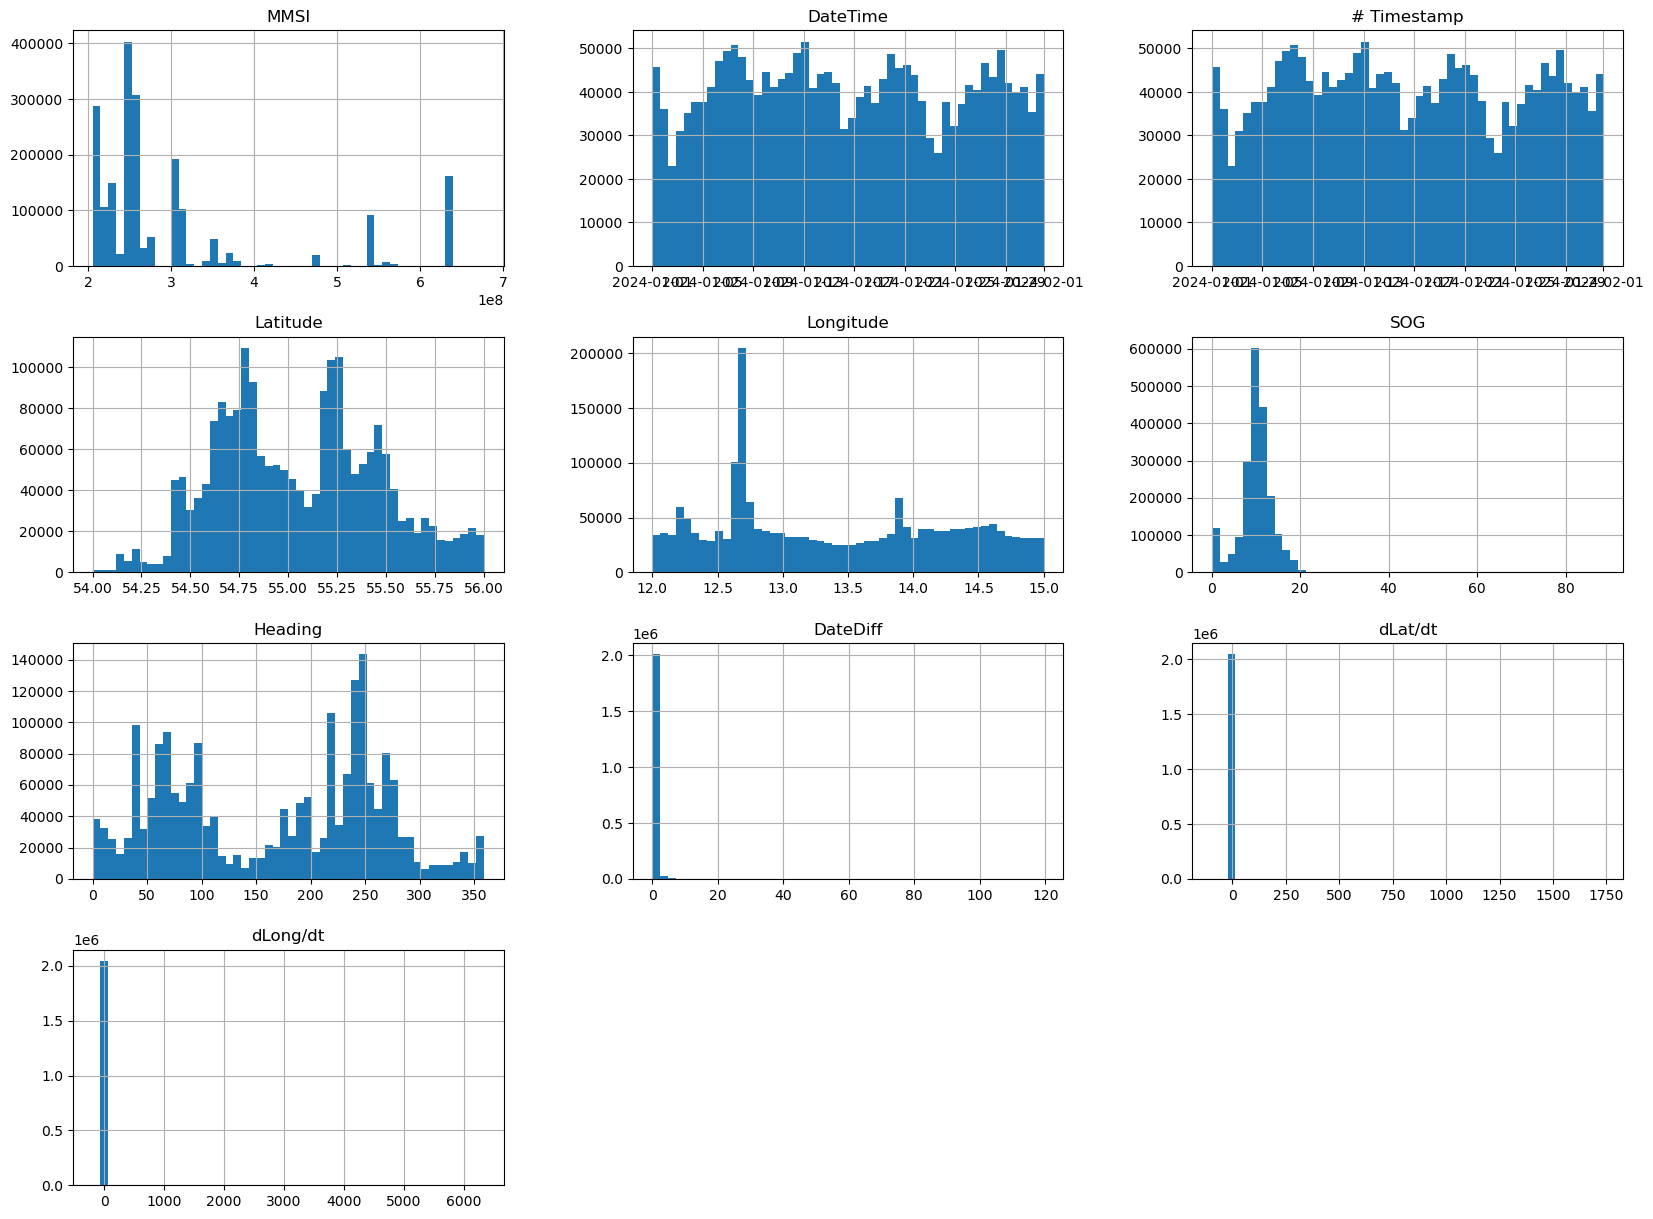

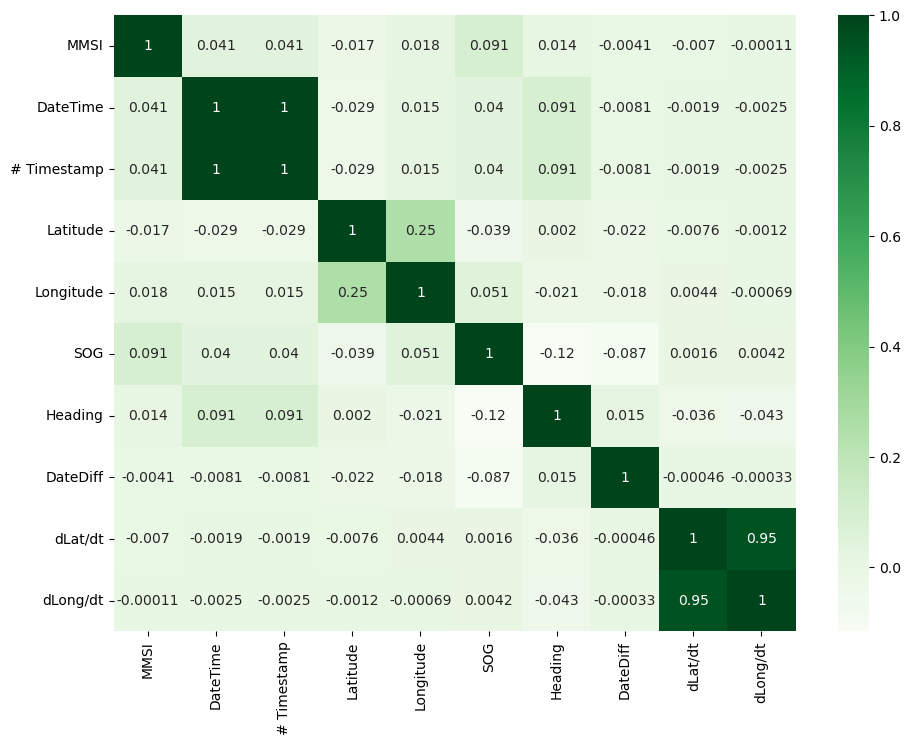

In [56]:
# Statistics - Plot histograms and correlation matrix
plt.figure(figsize=(5,5))
data.hist(bins=50, figsize=(20,15))
plt.show()


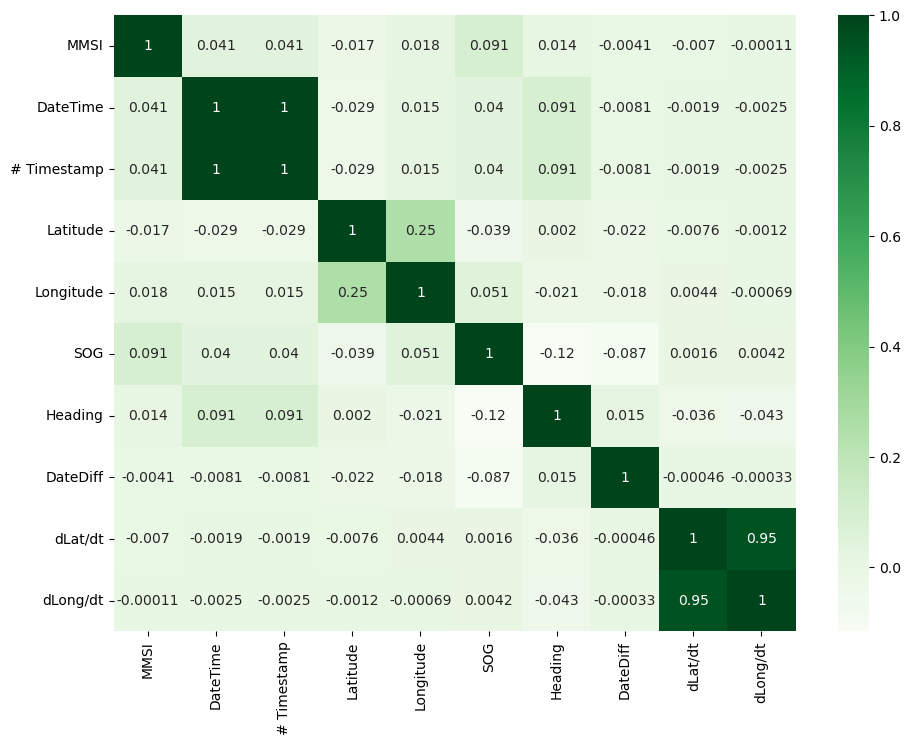

In [39]:
corr_matrix = data.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr_matrix, cmap="Greens",annot=True)
plt.show()
#del corr_matrix

In [41]:
corr_matrix

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
MMSI,1.000000,0.041091,0.041091,-0.017185,0.017900,0.090993,0.013864,-0.004090,-0.007008,-0.000109
DateTime,0.041091,1.000000,1.000000,-0.029314,0.015088,0.039912,0.090543,-0.008142,-0.001942,-0.002538
# Timestamp,0.041091,1.000000,1.000000,-0.029314,0.015088,0.039911,0.090543,-0.008139,-0.001942,-0.002538
Latitude,-0.017185,-0.029314,-0.029314,1.000000,0.253549,-0.039489,0.002044,-0.022470,-0.007564,-0.001219
Longitude,0.017900,0.015088,0.015088,0.253549,1.000000,0.050907,-0.021372,-0.018175,0.004385,-0.000692
SOG,0.090993,0.039912,0.039911,-0.039489,0.050907,1.000000,-0.116129,-0.087128,0.001632,0.004228
Heading,0.013864,0.090543,0.090543,0.002044,-0.021372,-0.116129,1.000000,0.014761,-0.036189,-0.043452
DateDiff,-0.004090,-0.008142,-0.008139,-0.022470,-0.018175,-0.087128,0.014761,1.000000,-0.000461,-0.000331
dLat/dt,-0.007008,-0.001942,-0.001942,-0.007564,0.004385,0.001632,-0.036189,-0.000461,1.000000,0.949004
dLong/dt,-0.000109,-0.002538,-0.002538,-0.001219,-0.000692,0.004228,-0.043452,-0.000331,0.949004,1.000000


In [43]:
# Assuming your DataFrame is named df 
pairwise_corr_matrix = data.corr() # Display the pairwise correlation matrix 
pairwise_corr_matrix

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
MMSI,1.000000,0.041091,0.041091,-0.017185,0.017900,0.090993,0.013864,-0.004090,-0.007008,-0.000109
DateTime,0.041091,1.000000,1.000000,-0.029314,0.015088,0.039912,0.090543,-0.008142,-0.001942,-0.002538
# Timestamp,0.041091,1.000000,1.000000,-0.029314,0.015088,0.039911,0.090543,-0.008139,-0.001942,-0.002538
Latitude,-0.017185,-0.029314,-0.029314,1.000000,0.253549,-0.039489,0.002044,-0.022470,-0.007564,-0.001219
Longitude,0.017900,0.015088,0.015088,0.253549,1.000000,0.050907,-0.021372,-0.018175,0.004385,-0.000692
SOG,0.090993,0.039912,0.039911,-0.039489,0.050907,1.000000,-0.116129,-0.087128,0.001632,0.004228
Heading,0.013864,0.090543,0.090543,0.002044,-0.021372,-0.116129,1.000000,0.014761,-0.036189,-0.043452
DateDiff,-0.004090,-0.008142,-0.008139,-0.022470,-0.018175,-0.087128,0.014761,1.000000,-0.000461,-0.000331
dLat/dt,-0.007008,-0.001942,-0.001942,-0.007564,0.004385,0.001632,-0.036189,-0.000461,1.000000,0.949004
dLong/dt,-0.000109,-0.002538,-0.002538,-0.001219,-0.000692,0.004228,-0.043452,-0.000331,0.949004,1.000000


In [57]:
len(data)

2045452

In [58]:
data.head()

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
1,205011000.0,2024-01-06 04:48:57,2024-01-06 04:49:00,54.705317,13.307098,10.5,260.0,0.850000,-0.037906,-0.349482
2,205011000.0,2024-01-06 04:49:48,2024-01-06 04:50:00,54.704780,13.302147,10.5,259.0,1.166667,-0.034611,-0.298646
3,205011000.0,2024-01-06 04:50:58,2024-01-06 04:51:00,54.704107,13.296340,10.6,259.0,1.000000,-0.033120,-0.302280
4,205011000.0,2024-01-06 04:51:58,2024-01-06 04:52:00,54.703555,13.291302,10.6,259.0,1.166667,-0.032760,-0.297874
5,205011000.0,2024-01-06 04:53:08,2024-01-06 04:53:00,54.702918,13.285510,10.7,260.0,0.833333,-0.032760,-0.311544


In [59]:
# Save the DataFrame to a CSV file
data.to_csv('new_jan_processed_data.csv', index=False)

In [17]:
# Load the CSV file
data = pd.read_csv('new_jan_processed_data.csv')

# Adjust the index to start from 1
data.index = data.index + 1

In [21]:
data.head()

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
1,205011000.0,2024-01-06 04:48:57,2024-01-06 04:49:00,54.705317,13.307098,10.5,260.0,0.850000,-0.037906,-0.349482
2,205011000.0,2024-01-06 04:49:48,2024-01-06 04:50:00,54.704780,13.302147,10.5,259.0,1.166667,-0.034611,-0.298646
3,205011000.0,2024-01-06 04:50:58,2024-01-06 04:51:00,54.704107,13.296340,10.6,259.0,1.000000,-0.033120,-0.302280
4,205011000.0,2024-01-06 04:51:58,2024-01-06 04:52:00,54.703555,13.291302,10.6,259.0,1.166667,-0.032760,-0.297874
5,205011000.0,2024-01-06 04:53:08,2024-01-06 04:53:00,54.702918,13.285510,10.7,260.0,0.833333,-0.032760,-0.311544


In [22]:
len(data)

2045452

In [23]:
# Sequencing - Define sequence parameters
seq_input_length = 30
seq_output_length = 20
seq_length = seq_input_length + seq_output_length
window_size = seq_length // 2


In [24]:
# Sequencing - Create sequences
seq = []
for i in range(0, len(data) - seq_length + 1, window_size):
    temp = data[i: i + seq_length].values
    if(temp[0,0] == temp[-1,0]):
        seq.append(temp)

# Convert the sequence list to a NumPy array and save it before shuffling
seq_array = np.array(seq)
np.save("sequences_before_shuffle.npy", seq_array)


In [25]:
# Shuffle the sequences
seq_array = np.dstack(seq_array)
seq_array = np.rollaxis(seq_array, -1)
seq_array = shuffle(seq_array)

# Save the sequences after shuffling
np.save("sequences_after_shuffle.npy", seq_array)


In [26]:
# Check the length of the sequences
sequence_length = seq_array.shape[1]
print(f"Length of each sequence: {sequence_length}")

Length of each sequence: 50


In [68]:
# Count the number of sequences created for each MMSI
mmsi_counts = {}
for sequence in seq_array:
    mmsi = sequence[0, 0]  # Assuming MMSI is in the first column
    if mmsi in mmsi_counts:
        mmsi_counts[mmsi] += 1
    else:
        mmsi_counts[mmsi] = 1

# Print the number of sequences created for each MMSI
for mmsi, count in mmsi_counts.items():
    print(f"MMSI: {mmsi}, Number of sequences: {count}")

# Print the total number of sequences created
total_sequences = len(seq_array)
print(f"Total number of sequences created: {total_sequences}")

MMSI: 636091859.0, Number of sequences: 116
MMSI: 636021044.0, Number of sequences: 64
MMSI: 212963000.0, Number of sequences: 36
MMSI: 257975000.0, Number of sequences: 103
MMSI: 209313000.0, Number of sequences: 120
MMSI: 219110000.0, Number of sequences: 95
MMSI: 209982000.0, Number of sequences: 63
MMSI: 538007283.0, Number of sequences: 34
MMSI: 311001027.0, Number of sequences: 36
MMSI: 244638000.0, Number of sequences: 36
MMSI: 246302000.0, Number of sequences: 28
MMSI: 255806328.0, Number of sequences: 430
MMSI: 258687000.0, Number of sequences: 1053
MMSI: 311001035.0, Number of sequences: 19
MMSI: 265412000.0, Number of sequences: 174
MMSI: 277561000.0, Number of sequences: 237
MMSI: 231023000.0, Number of sequences: 105
MMSI: 636018756.0, Number of sequences: 58
MMSI: 305662000.0, Number of sequences: 87
MMSI: 210525000.0, Number of sequences: 89
MMSI: 355390000.0, Number of sequences: 116
MMSI: 354537000.0, Number of sequences: 54
MMSI: 210534000.0, Number of sequences: 73
M

#### Creating a subset of the Data for test purposes - 

In [28]:
# Get unique MMSI values
unimmsi = data['MMSI'].unique()

# Select a subset of 500 unique MMSI values
subset_mmsi = unimmsi[:500]

# Create a subset of the DataFrame with the selected MMSI values
subset_df = data[data['MMSI'].isin(subset_mmsi)]

In [29]:
len(unimmsi)

1416

In [30]:
len(subset_df)

832291

In [72]:
subset_df.head()

,MMSI,DateTime,# Timestamp,Latitude,Longitude,SOG,Heading,DateDiff,dLat/dt,dLong/dt
1,205011000.0,2024-01-06 04:48:57,2024-01-06 04:49:00,54.705317,13.307098,10.5,260.0,0.850000,-0.037906,-0.349482
2,205011000.0,2024-01-06 04:49:48,2024-01-06 04:50:00,54.704780,13.302147,10.5,259.0,1.166667,-0.034611,-0.298646
3,205011000.0,2024-01-06 04:50:58,2024-01-06 04:51:00,54.704107,13.296340,10.6,259.0,1.000000,-0.033120,-0.302280
4,205011000.0,2024-01-06 04:51:58,2024-01-06 04:52:00,54.703555,13.291302,10.6,259.0,1.166667,-0.032760,-0.297874
5,205011000.0,2024-01-06 04:53:08,2024-01-06 04:53:00,54.702918,13.285510,10.7,260.0,0.833333,-0.032760,-0.311544


In [73]:
# Save the DataFrame to a CSV file
subset_df.to_csv('new_subset_jan_processed_data.csv', index=False)

In [74]:
# Sequencing - Create sequences
seq = []
for i in range(0, len(subset_df) - seq_length + 1, window_size):
    temp = subset_df[i: i + seq_length].values
    if(temp[0,0] == temp[-1,0]):
        seq.append(temp)

# Convert the sequence list to a NumPy array and save it before shuffling
seq_array = np.array(seq)
np.save("subset_sequences_before_shuffle.npy", seq_array)

In [75]:
# Shuffle the sequences
seq_array = np.dstack(seq_array)
seq_array = np.rollaxis(seq_array, -1)
seq_array = shuffle(seq_array)

# Save the sequences after shuffling
np.save("subset_sequences_after_shuffle.npy", seq_array)

In [76]:
len(subset_df)

832291